#  Detecting Insults in Social Commentary

## 1. Business Understanding

### 1.1 Project description

There is no doubt that the significance of monitoring and moderating online platforms has become increasingly important. Online spaces, especially public spaces such as social media, games, forums, chatting and dating applications allows us to meet new individuals, express opinions, provide feedback or reviews and engage in discussions.

However, not all of those interactions are constructive or respectful. Some online users take advantage of their anonymity and the lack of consequences to post insulting comments or inflamatory messages, and sometimes even to send death threats. This cyber-bullying results in discomfort for the entire community, even discouraging some users from using the web.

A possible solution to this critical problem is the implementation of a system that can detect whether or not a given message is insulting and takes appropriate action against it, by alerting moderators and/or admins & applying automatic bans and/or penalties.

### 1.2 Project objectives

The project is driven by the following key objectives:
| Objective | How? |
| --- | --- |
| Help moderate forums and discussions | Classify comments into two categories: non-insulting and insulting. |
| Take unbiased and precise decisions | Predictions would focus on obvious and direct insults rather than on subtle or ambiguous ones. |
| Prevent cyber-bullying and harassment | Model's automated and very quick predictions can expedite intervention and enhance prevention. |


## 2. Import Dependencies

These are all the dependencies that need to be installed and imported for the code to work in the chapters below.

In [ ]:
import re
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import class_weight
from sklearn import metrics
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download("punkt")

## 3. Data Understanding

### 3.1. Importing the data

In [2]:
# Using pandas to read the train data stored in a CSV file
train_data_path = 'data/train.csv'
train_data = pd.read_csv(train_data_path, encoding="utf-8")

#Displaying some rows from the train data
pd.set_option('display.max_colwidth', None)
train_data.head(10)

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It seems that you are mixing apples and oranges."""
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has been wrong before now and will be again.\\n\\nUnless you're supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them's the breaks and we can always regard you as collateral damage like in wartime - and sorry, but\\xc2\\xa0the cheques in the mail. """
3,0,NaN,"""listen if you dont wanna get married to a man or a women DONT DO IT. what would it bother you if gay people got married stay in your lane do you let them do them. And your god is so nice but quick to judg if your not like him, thought you wasnt suppose to judge people."""
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddng bi\u1ec3u t\xecnh 2011 c\xf3 \xf4n ho\xe0 kh\xf4ng ? \nC\xe1c ng\u01b0 d\xe2n ng\u1ed3i cu\xed \u0111\u1ea7u chi\u1ee5 nh\u1ee5c c\xf3 \xf4n ho\xe0 kh\xf4ng ?\nC\xe1c n\xf4ng d\xe2n gi\u1eef \u0111\u1ea5t \u1edf V\u0103n Giang, C\u1ea7n Th\u01a1 c\xf3 \xf4n ho\xe0 kh\xf4ng ?\n.................\nR\u1ed1t cu\u1ed9c \u0111\u01b0\u1ee3c g\xec\xa0 th\xec ch\xfang ta \u0111\xe3 bi\u1ebft !\nAi c\u0169ng y\xeau chu\u1ed9ng ho\xe0 b\xecnh, nh\u01b0ng \u0111\xf4i khi ho\xe0 b\xecnh ch\u1ec9 th\u1eadt s\u1ef1 \u0111\u1ebfn sau chi\u1ebfn tranh m\xe0 th\xf4i.\nKh\xf4ng c\xf2n con \u0111\u01b0\u1eddng n\xe0o ch\u1ecdn kh\xe1c \u0111\xe2u, \u0111\u1eebng m\u01a1 th\xeam n\u01b0\xe3."""
5,0,20120620171226Z,"""@SDL OK, but I would hope they'd sign him to a one-year contract to start with. Give him the chance to be reliable and productive, but give themselves the out if all his time off has hurt his playing skills or if he falls back into old habits."""
6,0,20120503012628Z,"""Yeah and where are you now?"""
7,1,NaN,"""shut the fuck up. you and the rest of your faggot friends should be burned at the stake"""
8,1,20120502173553Z,"""Either you are fake or extremely stupid...maybe both..."""
9,1,20120620160512Z,"""That you are an idiot who understands neither taxation nor women's health."""


### 3.2. Data exploration

### 3.2.1 Dataset description

The dataset used above, called "train.csv", was obtained from Kaggle, a platform that serves as an online community and competitions organizer for data scientists and machine learning practitioners around the world.

The dataset can be downloaded online from the following link: https://www.kaggle.com/competitions/detecting-insults-in-social-commentary/data

In [3]:
train_data.describe()

,Insult
count,3947.000000
mean,0.265771
std,0.441799
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


As you can see, the dataset consists of <b>3947</b> samples. Each sample represents a comment with a corresponding date and an insult label.

In the section below, we will discuss the columns and the meaning of their contents.

### 3.2.2 Columns description

In [4]:
train_data.head(2)

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It seems that you are mixing apples and oranges."""


The dataset is structured by 3 columns:

<b>Insult:</b> this column containts integer labels, where 1 indicates an insult comment, and 0 indicates a non-insulting comment.

<b>Date:</b> this column contains a timestamp at which the comment was posted/sent online. It represents local time and is expressed using this format "YYYYMMDDhhmmss".

In [8]:
train_data.isnull().sum()

Insult       0
Date       718
Comment      0
dtype: int64

The code above shows that some comments don't have associated dates with them, and so that should be taken into consideration when implementing the insult detection system.

<b>Comment:</b> this column contains an unicode-escaped text that's surrounded by double-quotes. The content is mostly expressed in English, with some occasional/informal formatting. It is necessary to pre-process these comments and turn them into a similar format that can be easily understood by the insult detection system.

## 4. Data preparation and pre-processing

### 4.1. Data cleaning

This chapter is about preparing data for analysis by cleaning it. This includes handling special and non alphanumeric characters, embeds, links and making it fields more readable.

In [3]:
def clean_dataset(dataset):

# Creating a new column that stores the original comment before cleaning
    dataset['Original Comment'] = dataset['Comment'].copy()
    
# Converting all uppercase letters to lower case for ease of comparaison later on
    dataset['Comment'] = dataset['Comment'].str.lower()
    
# Removing new lines
    dataset['Comment'] = dataset['Comment'].replace(r'\n', '')

# Removing all HTML tags, non alphanumeric, embeds and links
    dataset['Comment'] = dataset['Comment'].replace('[^\w\s]',' ', regex=True)
    dataset['Comment'] = dataset['Comment'].replace('http\S+','', regex=True)
    dataset['Comment'] = dataset['Comment'].replace('www\S+','', regex=True)
    dataset['Comment'] = dataset['Comment'].replace('_',' ', regex=True)

# Removing all the non ASCII characters
    dataset['Comment'] = dataset["Comment"].map(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))
    
# Trimming all leading and trailing white spaces
    dataset['Comment'] = dataset['Comment'].str.strip()

# Creating a new column that stores the original date format before cleaning
    dataset['Original Date'] = dataset['Date'].copy()

# Making dates more readable
    dataset['Date'] = dataset['Date'].fillna("Unknown")
    dataset['Date'] = dataset['Date'].apply(lambda date_str: "Unknown" if date_str == "Unknown" else datetime.datetime.strptime(date_str, '%Y%m%d%H%M%SZ'))
    
    return

In [4]:
clean_dataset(train_data)

In [5]:
train_data.head(10)

,Insult,Date,Comment,Original Comment,Original Date
0,1,2012-06-18 19:21:55,you fuck your dad,"""You fuck your dad.""",20120618192155Z
1,0,2012-05-28 19:22:15,i really don t understand your point xa0 it seems that you are mixing apples and oranges,"""i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.""",20120528192215Z
2,0,Unknown,a xc2 xa0majority of canadians can and has been wrong before now and will be again n nunless you re supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them s the breaks and we can always regard you as collateral damage like in wartime and sorry but xc2 xa0the cheques in the mail,"""A\\xc2\\xa0majority of Canadians can and has been wrong before now and will be again.\\n\\nUnless you're supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them's the breaks and we can always regard you as collateral damage like in wartime - and sorry, but\\xc2\\xa0the cheques in the mail. """,NaN
3,0,Unknown,listen if you dont wanna get married to a man or a women dont do it what would it bother you if gay people got married stay in your lane do you let them do them and your god is so nice but quick to judg if your not like him thought you wasnt suppose to judge people,"""listen if you dont wanna get married to a man or a women DONT DO IT. what would it bother you if gay people got married stay in your lane do you let them do them. And your god is so nice but quick to judg if your not like him, thought you wasnt suppose to judge people.""",NaN
4,0,2012-06-19 09:47:53,c xe1c b u1ea1n xu u1ed1ng u0111 u01b0 u1eddng bi u1ec3u t xecnh 2011 c xf3 xf4n ho xe0 kh xf4ng nc xe1c ng u01b0 d xe2n ng u1ed3i cu xed u0111 u1ea7u chi u1ee5 nh u1ee5c c xf3 xf4n ho xe0 kh xf4ng nc xe1c n xf4ng d xe2n gi u1eef u0111 u1ea5t u1edf v u0103n giang c u1ea7n th u01a1 c xf3 xf4n ho xe0 kh xf4ng n nr u1ed1t cu u1ed9c u0111 u01b0 u1ee3c g xec xa0 th xec ch xfang ta u0111 xe3 bi u1ebft nai c u0169ng y xeau chu u1ed9ng ho xe0 b xecnh nh u01b0ng u0111 xf4i khi ho xe0 b xecnh ch u1ec9 th u1eadt s u1ef1 u0111 u1ebfn sau chi u1ebfn tranh m xe0 th xf4i nkh xf4ng c xf2n con u0111 u01b0 u1eddng n xe0o ch u1ecdn kh xe1c u0111 xe2u u0111 u1eebng m u01a1 th xeam n u01b0 xe3,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddng bi\u1ec3u t\xecnh 2011 c\xf3 \xf4n ho\xe0 kh\xf4ng ? \nC\xe1c ng\u01b0 d\xe2n ng\u1ed3i cu\xed \u0111\u1ea7u chi\u1ee5 nh\u1ee5c c\xf3 \xf4n ho\xe0 kh\xf4ng ?\nC\xe1c n\xf4ng d\xe2n gi\u1eef \u0111\u1ea5t \u1edf V\u0103n Giang, C\u1ea7n Th\u01a1 c\xf3 \xf4n ho\xe0 kh\xf4ng ?\n.................\nR\u1ed1t cu\u1ed9c \u0111\u01b0\u1ee3c g\xec\xa0 th\xec ch\xfang ta \u0111\xe3 bi\u1ebft !\nAi c\u0169ng y\xeau chu\u1ed9ng ho\xe0 b\xecnh, nh\u01b0ng \u0111\xf4i khi ho\xe0 b\xecnh ch\u1ec9 th\u1eadt s\u1ef1 \u0111\u1ebfn sau chi\u1ebfn tranh m\xe0 th\xf4i.\nKh\xf4ng c\xf2n con \u0111\u01b0\u1eddng n\xe0o ch\u1ecdn kh\xe1c \u0111\xe2u, \u0111\u1eebng m\u01a1 th\xeam n\u01b0\xe3.""",20120619094753Z
5,0,2012-06-20 17:12:26,sdl ok but i would hope they d sign him to a one year contract to start with give him the chance to be reliable and productive but give themselves the out if all his time off has hurt his playing skills or if he falls back into old habits,"""@SDL OK, but I would hope they'd sign him to a one-year contract to start with. Give him the chance to be reliable and productive, but give themselves the out if all his time off has hurt his playing skills or if he falls back into old habits.""",20120620171226Z
6,0,2012-05-03 01:26:28,yeah and where are you now,"""Yeah and where are you now?""",20120503012628Z
7,1,Unknown,shut the fuck up you and the rest of your faggot friends should be burned at the stake,"""shut the fuck up. you and the rest of your faggot friends should be burned at the stake""",NaN
8,1,2012-05

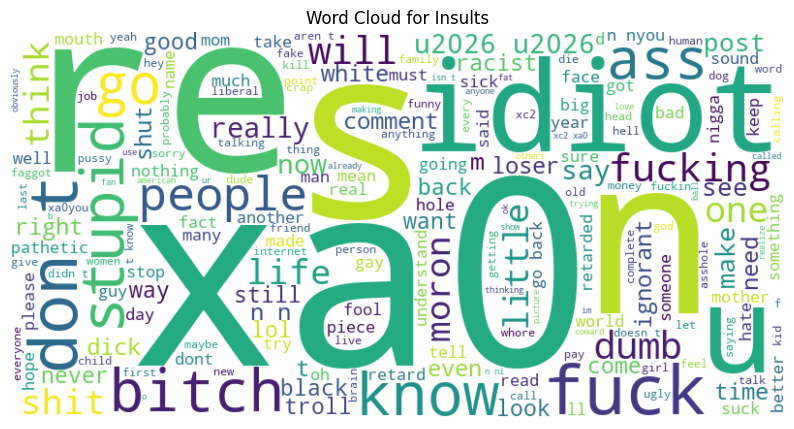

In [12]:
# Combine all transformed comments that belong to an insult into a single text
all_transformed_comment = ' '.join(train_data[train_data['Insult'] == 1]['Comment'])

# Create and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_transformed_comment)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Insults')

plt.show()

By performing <b>data visualization</b> like the example above, we notice that some symbols "xa0, re, c, s" and so on are not representative of a real insulting word. We believe these symbols are either part of spam comments, emoji representations, or other special symbols. These need to be removed from the data so that they don't interfere with the precision of the insult detection system.

We also noticed that some slangs like "u" are frequent in the insulting comments, but they shouldn't be treated as such.

### 4.2. Data reduction

This chapter is about reducing the dataset to a better representative subset, and also includes filtering out specific patterns, words and rows

In [6]:
def reduce_dataset(dataset, percentage=0.2):
    
    # Removing spam looking comments and specific patterns
    dataset['Comment'] = dataset['Comment'].replace(r'x[\w\d]+',' ', regex=True)
    dataset['Comment'] = dataset['Comment'].replace(r'\b(?:re|n|s)\b',' ', regex=True)
    dataset['Comment'] = dataset['Comment'].replace(r'u\d+', ' ', regex=True)

    # Remove elements that are not representative of dataset
    dataset.drop(4, inplace=True)
    dataset.reset_index(drop=True, inplace=True)

    return dataset

In [7]:
train_data = reduce_dataset(train_data)

In [8]:
train_data.head(10)

,Insult,Date,Comment,Original Comment,Original Date
0,1,2012-06-18 19:21:55,you fuck your dad,"""You fuck your dad.""",20120618192155Z
1,0,2012-05-28 19:22:15,i really don t understand your point it seems that you are mi apples and oranges,"""i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.""",20120528192215Z
2,0,Unknown,a of canadians can and has been wrong before now and will be again nunless you supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them the breaks and we can always regard you as collateral damage like in wartime and sorry but cheques in the mail,"""A\\xc2\\xa0majority of Canadians can and has been wrong before now and will be again.\\n\\nUnless you're supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them's the breaks and we can always regard you as collateral damage like in wartime - and sorry, but\\xc2\\xa0the cheques in the mail. """,NaN
3,0,Unknown,listen if you dont wanna get married to a man or a women dont do it what would it bother you if gay people got married stay in your lane do you let them do them and your god is so nice but quick to judg if your not like him thought you wasnt suppose to judge people,"""listen if you dont wanna get married to a man or a women DONT DO IT. what would it bother you if gay people got married stay in your lane do you let them do them. And your god is so nice but quick to judg if your not like him, thought you wasnt suppose to judge people.""",NaN
4,0,2012-06-20 17:12:26,sdl ok but i would hope they d sign him to a one year contract to start with give him the chance to be reliable and productive but give themselves the out if all his time off has hurt his playing skills or if he falls back into old habits,"""@SDL OK, but I would hope they'd sign him to a one-year contract to start with. Give him the chance to be reliable and productive, but give themselves the out if all his time off has hurt his playing skills or if he falls back into old habits.""",20120620171226Z
5,0,2012-05-03 01:26:28,yeah and where are you now,"""Yeah and where are you now?""",20120503012628Z
6,1,Unknown,shut the fuck up you and the rest of your faggot friends should be burned at the stake,"""shut the fuck up. you and the rest of your faggot friends should be burned at the stake""",NaN
7,1,2012-05-02 17:35:53,either you are fake or e stupid maybe both,"""Either you are fake or extremely stupid...maybe both...""",20120502173553Z
8,1,2012-06-20 16:05:12,that you are an idiot who understands neither ta nor women health,"""That you are an idiot who understands neither taxation nor women's health.""",20120620160512Z
9,0,2012-06-20 01:51:40,jdstorm dont wish him injury but it happened on its own and i doubt he injured he looked embarrassed to me,"""@jdstorm dont wish him injury but it happened on its OWN and i DOUBT he's injured, he looked embarrassed to me""",20120620015140Z


### 4.3 Data transformation

This chapter is about preparing the dataset for the insult detection classification task. This includes tokenization of words, stop-word removal, stemming, and slang word replacement.

In [9]:
def transform_dataset(dataset):
    
# Tokenizing all the words in a given comment
    dataset['Tokenized Comment'] = dataset['Comment'].map(lambda row: nltk.word_tokenize(row))
    
# Removing stop words from tokenized comments
    stop_words_file = open("filters/stop_words.txt", 'r')
    stop_words_file = stop_words_file.read()
    stop_words_list = re.split('\n|,', stop_words_file)
    dataset['Tokenized Comment'] = dataset['Tokenized Comment'].apply(lambda x: [item for item in x if item not in stop_words_list])

# Stemming all the words
    stemmer = SnowballStemmer('english')
    dataset['Stemmed Comment'] = dataset["Tokenized Comment"].apply(lambda x: [stemmer.stem(y) for y in x])

# Replacing slang words with formal equivalent
    map_words = {"u": "you", "em":"them", "da":"the", "yo":"you", "ur":"you", "won't": "will not", "won't": "will not", "can't": "can not",
                 "i'm": "i am", "i'm": "i am", "ain't": "is not", "'ll": "will", "'t": "not", "'ve": "have", "'s": "is", "'re": "are", "'d": "would"}

    dataset['Improved Stemmed Comment'] = dataset["Stemmed Comment"].map(lambda x: [map_words[x[i]] if x[i] in map_words else x[i] for i in range(len(x)) ])

    dataset['Transformed Comment'] = \
            dataset["Improved Stemmed Comment"]. \
            map(lambda x: (' '.join(word for word in x)))
    
    dataset['Transformed Comment'].fillna(" ", inplace=True)
    
    return

In [10]:
transform_dataset(train_data)

In [11]:
train_data.head(10)

,Insult,Date,Comment,Original Comment,Original Date,Tokenized Comment,Stemmed Comment,Improved Stemmed Comment,Transformed Comment
0,1,2012-06-18 19:21:55,you fuck your dad,"""You fuck your dad.""",20120618192155Z,"[you, fuck, your, dad]","[you, fuck, your, dad]","[you, fuck, your, dad]",you fuck your dad
1,0,2012-05-28 19:22:15,i really don t understand your point it seems that you are mi apples and oranges,"""i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.""",20120528192215Z,"[i, really, don, t, understand, your, point, seems, you, mi, apples, oranges]","[i, realli, don, t, understand, your, point, seem, you, mi, appl, orang]","[i, realli, don, t, understand, your, point, seem, you, mi, appl, orang]",i realli don t understand your point seem you mi appl orang
2,0,Unknown,a of canadians can and has been wrong before now and will be again nunless you supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them the breaks and we can always regard you as collateral damage like in wartime and sorry but cheques in the mail,"""A\\xc2\\xa0majority of Canadians can and has been wrong before now and will be again.\\n\\nUnless you're supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them's the breaks and we can always regard you as collateral damage like in wartime - and sorry, but\\xc2\\xa0the cheques in the mail. """,NaN,"[a, canadians, can, wrong, now, will, nunless, you, supportive, idea, nothing, full, proof, perfect, you, take, your, chances, we, inadvertently, kill, your, son, daughter, then, them, breaks, we, can, always, regard, you, collateral, damage, like, wartime, sorry, cheques, mail]","[a, canadian, can, wrong, now, will, nunless, you, support, idea, noth, full, proof, perfect, you, take, your, chanc, we, inadvert, kill, your, son, daughter, then, them, break, we, can, alway, regard, you, collater, damag, like, wartim, sorri, chequ, mail]","[a, canadian, can, wrong, now, will, nunless, you, support, idea, noth, full, proof, perfect, you, take, your, chanc, we, inadvert, kill, your, son, daughter, then, them, break, we, can, alway, regard, you, collater, damag, like, wartim, sorri, chequ, mail]",a canadian can wrong now will nunless you support idea noth full proof perfect you take your chanc we inadvert kill your son daughter then them break we can alway regard you collater damag like wartim sorri chequ mail
3,0,Unknown,listen if you dont wanna get married to a man or a women dont do it what would it bother you if gay people got married stay in your lane do you let them do them and your god is so nice but quick to judg if your not like him thought you wasnt suppose to judge people,"""listen if you dont wanna get married to a man or a women DONT DO IT. what would it bother you if gay people got married stay in your lane do you let them do them. And your god is so nice but quick to judg if your not like him, thought you wasnt suppose to judge people.""",NaN,"[listen, you, dont, wan, na, get, married, a, man, a, women, dont, bother, you, gay, people, got, married, stay, your, lane, you, let, them, them, your, god, nice, quick, judg, your, like, him, thought, you, wasnt, suppose, judge, people]","[listen, you, dont, wan, na, get, marri, a, man, a, women, dont, bother, you, gay, peopl, got, marri, stay, your, lane, you, let, them, them, your, god, nice, quick, judg, your, like, him, thought, you, wasnt, suppos, judg, peopl]","[listen, you, dont, wan, na, get, marri, a, man, a, women, dont, bother, you, gay, peopl, got, marri, stay, your, lane, you, let, them, them, your, god, nice, quick, judg, your, like, him, thought, you, wasnt, suppos, judg, peopl]",listen you dont wan na get marri a man a women dont bother you gay peopl got marri stay your lane you let them them your god nice quick judg your 

### 4.4 Data visualization

This chapter is about visually presenting and exploring specific aspects of the dataset, such as the distribution of insult labels, the most frequent words in comments, and the trend of insults over time. It enables readers to gain better insights and understanding from the data.

<b>Distribution of Insult Labels:</b>

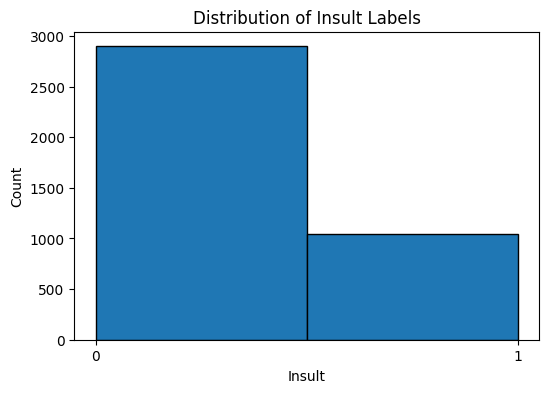

In [14]:
# Plot a histogram of insult distribution
plt.figure(figsize=(6, 4))
plt.hist(train_data['Insult'], bins=2, edgecolor='k')
plt.xlabel('Insult')
plt.ylabel('Count')
plt.title('Distribution of Insult Labels')
plt.xticks([0, 1])

plt.show()

<b>Word Cloud for Comments:</b>

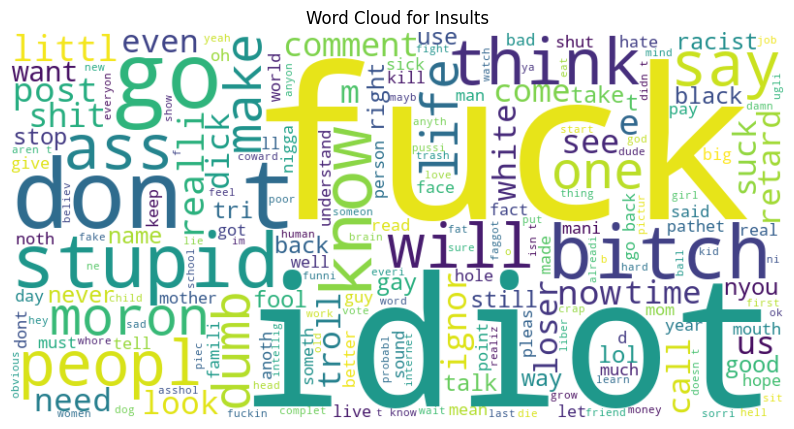

In [15]:
# Combine all transformed comments that belong to an insult into a single text
all_transformed_comment = ' '.join(train_data[train_data['Insult'] == 1]['Transformed Comment'])

# Create and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_transformed_comment)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Insults')

plt.show()

<b>Insults Over Time:</b>

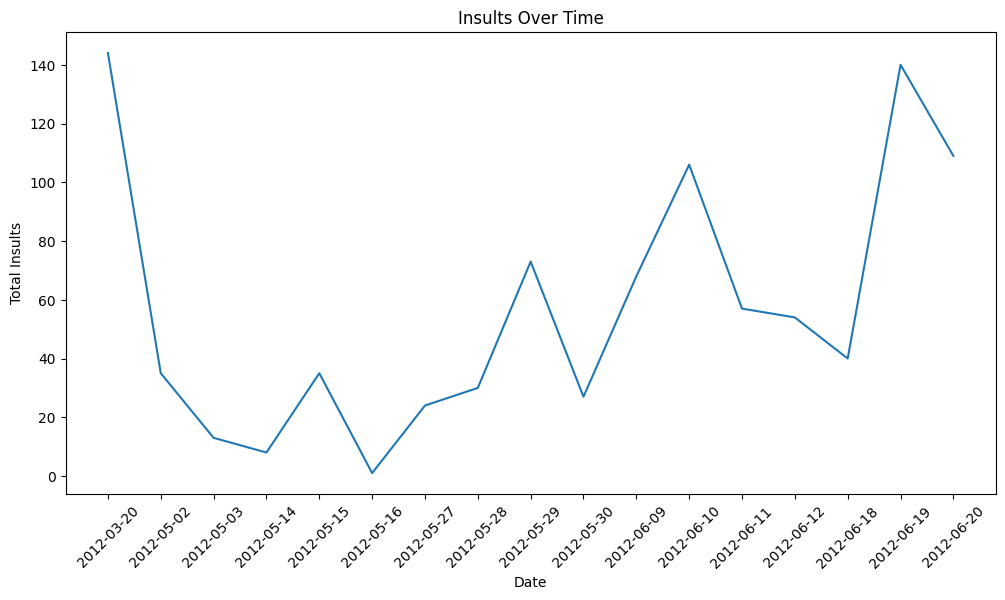

In [16]:
# Only use comments that have date associated with them
with_date_data_only = train_data[train_data['Date'] != 'Unknown'].copy()
with_date_data_only = with_date_data_only[with_date_data_only['Insult'] == 1].copy()
with_date_data_only['Date'] = with_date_data_only['Date'].astype(str)
with_date_data_only['Date'] = with_date_data_only['Date'].str.split(' ').str[0]

# Group by date and calculate the sum of insults
insult_counts = with_date_data_only.groupby('Date', as_index=False)['Insult'].sum()

# Create a time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=insult_counts, x='Date', y='Insult')
plt.xlabel('Date')
plt.ylabel('Total Insults')
plt.title('Insults Over Time')
plt.xticks(rotation=45)
plt.show()


## 5. Modeling & Evaluation

### 5.1 Feature selection

We decided to select the following columns:
- <b>Insult:</b> Labels of 0 or 1 that represent a non-insulting comment and an insulting one respectively.
- <b>Improved Stemmed Comment:</b> List of tokenized and transformed words that matter in a given comment.
- <b>Transformed Comment:</b> The comment rewritten using the tokenized and transformed words.

We decided to use the following to feed the data to our classifier:
- <b>Count Vectorizer:</b> Converts comment data into numerical vectors by counting the frequency of words in each document.
- <b>TF_IDF Transformer:</b> Measures the importance of words in a comment relative to a collection of comments by considering their frequency and uniqueness.
- <b>Bad Words Transformer:</b> Analyzes and counts the occurrence of offensive or inappropriate content in comments using Google's list of bad words.

Below is the implementation of the Bad Words Transformer. It extends the Transformer class provided by sklearn so that it could be used later on as part of the model's pipeline.

In [13]:
bad_words = open('filters/bad_words.txt', 'r')
input_text = bad_words.read() 
input_text = re.split('\n|,', input_text)
bad_words_list = [word.replace( u"\xa0",u"") for word in input_text]

# Transformer that takes into consideration the frequency of bad words in a given comment.
class BadWordTransformer(TransformerMixin):

    # Converts df to strings, splits each string into a list of words, and then counts the number of "bad words" present in each entry. 
    # The result is returned as a pandas DataFrame.
    def transform(self, df, **transform_params):
        df = df.astype('str').map(lambda x: x.split() if (x!='nan') else '')
        transformed = pd.DataFrame(df.map(lambda x: len(list(filter((lambda y: y in bad_words_list), x) ))))
        return transformed
        
    # Does nothing, just here because the TransformerMixin interface requires it to be implemented.
    def fit(self, df, y=None, **fit_params):
        return self

In order to use all the feature selection methods efficiently, we will create a pipeline that combines all of othem and returns the final processed data to the classifier. The diagram below explains how the pipeline would work

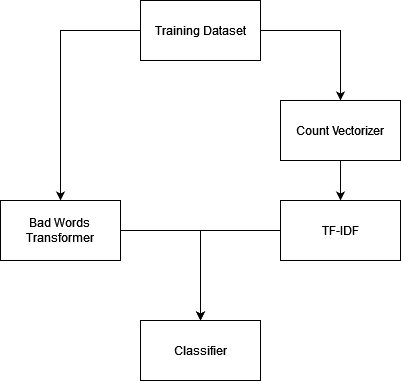

### 5.2 Model selection

### 5.2.1 Logistic Regression

Logistic Regression is a linear model that's suitable for a binary classification problems where the output is Yes or No. In the case of this project, classifying a comment as an insult, or as a non-insult fits this criteria. This model is efficient and is commonly used thanks to its low complexity and low risk of overfitting. It works well even when the data may not be correlated. It is also good when the training data is not fixes, as more incoming training data can easily be incorporated into the model.

<b>Modeling</b>

In [23]:
# Logistic Regresson
insult_classifier = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_idf', Pipeline([
            ('counts', CountVectorizer(ngram_range=(1, 2))),
            ('tf_idf', TfidfTransformer())
            ])),
        ('badwords', BadWordTransformer())
        ])),
    ('classifier', LogisticRegression())
    ])

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_data["Insult"]), y=train_data["Insult"])
insult_classifier.set_params(classifier__class_weight={0: class_weights[0], 1: class_weights[1]})
insult_classifier = insult_classifier.fit(train_data["Transformed Comment"],train_data["Insult"])

<b>Evaluation<b/>

In [24]:
# Import testing dataset
test_data_path = 'data/test.csv'
test_data = pd.read_csv(test_data_path, encoding="utf-8")

# Prepare testing dataset
clean_dataset(test_data)
test_data['Comment'] = test_data['Comment'].replace(r'x[\w\d]+',' ', regex=True)
test_data['Comment'] = test_data['Comment'].replace(r'\b(?:re|n|s)\b',' ', regex=True)
transform_dataset(test_data)

In [25]:
# Predict using comments from testing data
predicted = insult_classifier.predict(test_data["Transformed Comment"])

print("\nMetric Report of Logistic Regression:")
print(metrics.classification_report(test_data["Insult"], predicted, target_names=['Not an insult', 'Insult']))


Metric Report of Logistic Regression:
               precision    recall  f1-score   support

Not an insult       0.92      0.84      0.88      1954
       Insult       0.63      0.79      0.70       693

     accuracy                           0.82      2647
    macro avg       0.78      0.81      0.79      2647
 weighted avg       0.84      0.82      0.83      2647



<b>Accuracy:</b> 82%

<b>F1-Score:</b> 83%

Below are the results of the testing dataset, with its actual label (insult vs non-insult) and the predicted label.

In [27]:
result_df = pd.DataFrame({
    'Comment': test_data["Comment"],
    'Actual': test_data["Insult"],
    'Predicted': predicted
})

result_df.head(50)

,Comment,Actual,Predicted
0,the drudge report nyou won t see this story on fo forum because they suck biacks and gay 0bama all the way to the crack non tuesday rep darrell issa chairman of the house committee on noversight and government reform took a major step toward holding nattorney general eric holder in contempt of congress for his failure to nprovide subpoenaed documents and other information about operation fast nand furious nin a jan 31 letter issa had threatened holder with such a move if he nfailed to provide all the subpoenaed documents relating to the fast and nfurious gunwalking scandal by feb 9 that deadline has come and gone nand holder department of justice still hasn provided most of those ndocuments issa subpoena dates back to oct 12 2011 non tuesday in a seven page letter issa revealed that deputy attorney ngeneral james cole begged congress to e the feb 9 deadline issa nwrote that the request was and the reality that the ndepartment has unreasonably delayed producing these documents to the ncommittee its face the requested e demonstrates a lack of good nfaith issa wrote to holder one e the department has nonly produced documents responsive to the subpoena on the eve of ncongressional hearings in which senior department officials testified nthe department appears to be more concerned with protecting its image nthrough spin control than actually cooperating with congress cannot wait any longer for the department cooperation issa ncontinued such please specify a date by which you e the ndepartment to produce all documents responsive to the subpoena in naddition please specify a department representative who will interface nwith the committee for production purposes nissa added that whoever holder designates as the go to doj official for ndelivering subpoenaed documents also serve as the conduit for ndealing with the contempt proceedings should the department continue to ignore the committee subpoena related full coverage of eric nholder nthe california republican slammed holder too for claiming the ncongressional investigation into fast and furious was a political game nfor republicans nread more http dailycaller com 2012 02 14 issa takes step toward holding holder in contempt of congress i,0,0
1,ian21 roger clemens is the fucking man and never did any fucking steroids because he is fucking awesome did you all misremember roger incredibleness roger clemens,0,1
2,agree with alan you are an e idiot you are not american we native americans are you are an alien,1,1
3,really ni see marc lamont hill on various programs quite often as is al sharpton and michael moore even got his fat ass handed to him by bill o reilly nhow can you talk about a subject you obviously know nothing about,0,0
4,really suck isn t the word when many of our nuclear power plants start melting down it will literally be hell on earth in the us and we have no one else to blame but our own corrupt government,0,0
5,after a couple guys like him rape him first,0,0
6,matthews mentored perry at usc bodes well,0,0
7,how about we accept facts and patiently wait for you to back up your claim,0,1
8,to engage in an intelligent debate with you is like debating to a retarded person it useless it looks like you bent on disregarding the efforts of the government,1,1
9,same reason no one cared obama did cocaine which is a felony as well,0,0


### 5.2.2 Random Forest

Random Forest is an ensemble learning technique that creates numerous decision trees during the training process. The final prediction is determined by the most frequently occurring class among the predictions of the individual trees, making it a robust approach for classification tasks. This classifier mitigates the risk of overfitting and is better at considering instances where the presence of certain words alone might not be indicative of insults.

<b>Modeling<b/>

In [18]:
# Random Forest
insult_classifier = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_idf', Pipeline([
            ('counts', CountVectorizer(ngram_range=(1, 2))),
            ('tf_idf', TfidfTransformer())
            ])),
        ('badwords', BadWordTransformer())
        ])),
    ('classifier', RandomForestClassifier())
    ])

insult_classifier = insult_classifier.fit(train_data["Transformed Comment"],train_data["Insult"])

<b>Evaluation<b/>

In [19]:
# Import testing dataset
test_data_path = 'data/test.csv'
test_data = pd.read_csv(test_data_path, encoding="utf-8")

# Prepare testing dataset
clean_dataset(test_data)
test_data['Comment'] = test_data['Comment'].replace(r'x[\w\d]+',' ', regex=True)
test_data['Comment'] = test_data['Comment'].replace(r'\b(?:re|n|s)\b',' ', regex=True)
transform_dataset(test_data)

In [20]:
# Predict using comments from testing data
predicted = insult_classifier.predict(test_data["Transformed Comment"])

print("\nMetric Report of Random Forest:")
print(metrics.classification_report(test_data["Insult"], predicted, target_names=['Not an insult', 'Insult']))


Metric Report of Random Forest:
               precision    recall  f1-score   support

Not an insult       0.84      0.97      0.90      1954
       Insult       0.85      0.47      0.60       693

     accuracy                           0.84      2647
    macro avg       0.85      0.72      0.75      2647
 weighted avg       0.84      0.84      0.82      2647



<b>Accuracy:</b> 84%

<b>F1-Score:</b> 82%

Below are the results of the testing dataset, with its actual label (insult vs non-insult) and the predicted label.

In [22]:
result_df = pd.DataFrame({
    'Comment': test_data["Comment"],
    'Actual': test_data["Insult"],
    'Predicted': predicted
})

result_df.head(50)

,Comment,Actual,Predicted
0,the drudge report nyou won t see this story on fo forum because they suck biacks and gay 0bama all the way to the crack non tuesday rep darrell issa chairman of the house committee on noversight and government reform took a major step toward holding nattorney general eric holder in contempt of congress for his failure to nprovide subpoenaed documents and other information about operation fast nand furious nin a jan 31 letter issa had threatened holder with such a move if he nfailed to provide all the subpoenaed documents relating to the fast and nfurious gunwalking scandal by feb 9 that deadline has come and gone nand holder department of justice still hasn provided most of those ndocuments issa subpoena dates back to oct 12 2011 non tuesday in a seven page letter issa revealed that deputy attorney ngeneral james cole begged congress to e the feb 9 deadline issa nwrote that the request was and the reality that the ndepartment has unreasonably delayed producing these documents to the ncommittee its face the requested e demonstrates a lack of good nfaith issa wrote to holder one e the department has nonly produced documents responsive to the subpoena on the eve of ncongressional hearings in which senior department officials testified nthe department appears to be more concerned with protecting its image nthrough spin control than actually cooperating with congress cannot wait any longer for the department cooperation issa ncontinued such please specify a date by which you e the ndepartment to produce all documents responsive to the subpoena in naddition please specify a department representative who will interface nwith the committee for production purposes nissa added that whoever holder designates as the go to doj official for ndelivering subpoenaed documents also serve as the conduit for ndealing with the contempt proceedings should the department continue to ignore the committee subpoena related full coverage of eric nholder nthe california republican slammed holder too for claiming the ncongressional investigation into fast and furious was a political game nfor republicans nread more http dailycaller com 2012 02 14 issa takes step toward holding holder in contempt of congress i,0,0
1,ian21 roger clemens is the fucking man and never did any fucking steroids because he is fucking awesome did you all misremember roger incredibleness roger clemens,0,0
2,agree with alan you are an e idiot you are not american we native americans are you are an alien,1,1
3,really ni see marc lamont hill on various programs quite often as is al sharpton and michael moore even got his fat ass handed to him by bill o reilly nhow can you talk about a subject you obviously know nothing about,0,0
4,really suck isn t the word when many of our nuclear power plants start melting down it will literally be hell on earth in the us and we have no one else to blame but our own corrupt government,0,0
5,after a couple guys like him rape him first,0,0
6,matthews mentored perry at usc bodes well,0,0
7,how about we accept facts and patiently wait for you to back up your claim,0,0
8,to engage in an intelligent debate with you is like debating to a retarded person it useless it looks like you bent on disregarding the efforts of the government,1,1
9,same reason no one cared obama did cocaine which is a felony as well,0,0


### 5.2.3 Linear SVC

Linear SVC stands for "Linear Support Vector Classification." It is a type of support vector machine designed for linearly separable data, aiming to find a hyperplane that best separates instances of different classes. In the case of this project, the classifier strives to find the optimal linear boundary that effectively separates insults from non-insults. It performs well with diverse vocabulary and linguistic patterns. Since insults and non-insults have discernible patterns, it can also find an optimal hyperplane to maximize the margin, leading to a clear separation between the two classes.

<b>Modeling</b>

In [ ]:
# Linear SVC
insult_classifier = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_idf', Pipeline([
            ('counts', CountVectorizer(ngram_range=(1, 2))),
            ('tf_idf', TfidfTransformer())
            ])),
        ('badwords', BadWordTransformer())
        ])),
    ('classifier',  LinearSVC(max_iter=2000))
    ])

insult_classifier = insult_classifier.fit(train_data["Transformed Comment"],train_data["Insult"])

<b>Evaluation<b/>

In [29]:
# Import testing dataset
test_data_path = 'data/test.csv'
test_data = pd.read_csv(test_data_path, encoding="utf-8")

# Prepare testing dataset
clean_dataset(test_data)
test_data['Comment'] = test_data['Comment'].replace(r'x[\w\d]+',' ', regex=True)
test_data['Comment'] = test_data['Comment'].replace(r'\b(?:re|n|s)\b',' ', regex=True)
transform_dataset(test_data)

In [26]:
# Predict using comments from testing data
predicted = insult_classifier.predict(test_data["Transformed Comment"])

print("\nMetric Report of Linear SVC:")
print(metrics.classification_report(test_data["Insult"], predicted, target_names=['Not an insult', 'Insult']))


Metric Report of Linear SVC:
               precision    recall  f1-score   support

Not an insult       0.87      0.94      0.91      1954
       Insult       0.78      0.62      0.69       693

     accuracy                           0.86      2647
    macro avg       0.83      0.78      0.80      2647
 weighted avg       0.85      0.86      0.85      2647



<b>Accuracy:</b> 86%

<b>F1-Score:</b> 85%

Below are the results of the testing dataset, with its actual label (insult vs non-insult) and the predicted label.

In [30]:
result_df = pd.DataFrame({
    'Comment': test_data["Comment"],
    'Actual': test_data["Insult"],
    'Predicted': predicted
})

result_df.head(50)

,Comment,Actual,Predicted
0,the drudge report nyou won t see this story on fo forum because they suck biacks and gay 0bama all the way to the crack non tuesday rep darrell issa chairman of the house committee on noversight and government reform took a major step toward holding nattorney general eric holder in contempt of congress for his failure to nprovide subpoenaed documents and other information about operation fast nand furious nin a jan 31 letter issa had threatened holder with such a move if he nfailed to provide all the subpoenaed documents relating to the fast and nfurious gunwalking scandal by feb 9 that deadline has come and gone nand holder department of justice still hasn provided most of those ndocuments issa subpoena dates back to oct 12 2011 non tuesday in a seven page letter issa revealed that deputy attorney ngeneral james cole begged congress to e the feb 9 deadline issa nwrote that the request was and the reality that the ndepartment has unreasonably delayed producing these documents to the ncommittee its face the requested e demonstrates a lack of good nfaith issa wrote to holder one e the department has nonly produced documents responsive to the subpoena on the eve of ncongressional hearings in which senior department officials testified nthe department appears to be more concerned with protecting its image nthrough spin control than actually cooperating with congress cannot wait any longer for the department cooperation issa ncontinued such please specify a date by which you e the ndepartment to produce all documents responsive to the subpoena in naddition please specify a department representative who will interface nwith the committee for production purposes nissa added that whoever holder designates as the go to doj official for ndelivering subpoenaed documents also serve as the conduit for ndealing with the contempt proceedings should the department continue to ignore the committee subpoena related full coverage of eric nholder nthe california republican slammed holder too for claiming the ncongressional investigation into fast and furious was a political game nfor republicans nread more http dailycaller com 2012 02 14 issa takes step toward holding holder in contempt of congress i,0,0
1,ian21 roger clemens is the fucking man and never did any fucking steroids because he is fucking awesome did you all misremember roger incredibleness roger clemens,0,1
2,agree with alan you are an e idiot you are not american we native americans are you are an alien,1,1
3,really ni see marc lamont hill on various programs quite often as is al sharpton and michael moore even got his fat ass handed to him by bill o reilly nhow can you talk about a subject you obviously know nothing about,0,0
4,really suck isn t the word when many of our nuclear power plants start melting down it will literally be hell on earth in the us and we have no one else to blame but our own corrupt government,0,0
5,after a couple guys like him rape him first,0,0
6,matthews mentored perry at usc bodes well,0,0
7,how about we accept facts and patiently wait for you to back up your claim,0,1
8,to engage in an intelligent debate with you is like debating to a retarded person it useless it looks like you bent on disregarding the efforts of the government,1,1
9,same reason no one cared obama did cocaine which is a felony as well,0,0


## 5. Insights, Conclusions and Business recommendations

A one-page report dicussing these points can be accessed through this link: <a href = "./Detecting Insults In Social Commentary - Insight, Business, Future Work.pdf">Link to PDF File</a>